In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics as m
import multiprocessing
from gensim.models.word2vec import Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
from gensim.models.phrases import Phrases, Phraser
import nltk
print(cores)
from time import time
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
print(tf.__version__)

4
2.4.0


In [73]:
dataset = pd.read_csv('/home/aayush/task3_midas/datasets/imbalanced_dataset_200.csv')
train, test = model_selection.train_test_split(dataset, test_size=0.3)
x_train = train["pre_processed_text"].values
x_test = test["pre_processed_text"].values
y_train = train["category"].values
y_test = test["category"].values
print("our training set contains %d examples"%(len(x_train)))
print("our test set contains %d examples"%(len(x_test)))

our training set contains 11090 examples
our test set contains 4754 examples


In [79]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
print(y_train)
print(y_test)
Y_train = np.array([inverse_dic[y] for y in y_train])
Y_test = np.array([inverse_dic[y] for y in y_test])
print(Y_train)
print(Y_test)

['BeautyandPersonalCare' 'Jewellery' 'Footwear' ... "Men'sClothing"
 'Kitchen&Dining' "Men'sClothing"]
['HomeFurnishing' 'Automotive' 'Jewellery' ... 'Computers'
 "Women'sClothing" 'Sports&Fitness']
[ 3  9  5 ... 12 11 12]
[ 8  0  9 ...  4 19 15]


In [80]:
w2v_model = Word2Vec(vector_size = 300,window=8, min_count=1, sg=1,  workers=cores-1)
word_sentences = list()
for x in x_train:
    word_sentences.append(x.split())
t = time()
w2v_model.build_vocab(word_sentences, progress_per=100)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print(len(word_sentences))

Time to build vocab: 0.01 mins
11090


In [81]:
t = time()

w2v_model.train(word_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to train the model: 1.74 mins


In [82]:
w2v_model.wv.most_similar(positive=['girlfriend'])

[('sister', 0.7929148077964783),
 ('scroll', 0.7213189601898193),
 ('friendship', 0.7204555869102478),
 ('boyfriend', 0.7081845998764038),
 ('brother', 0.697708249092102),
 ('indilego', 0.6957976818084717),
 ('kanvas', 0.6923874020576477),
 ('modinn', 0.6795862913131714),
 ('fashionpedia', 0.6672123074531555),
 ('redwhite', 0.6669962406158447)]

In [83]:
print(w2v_model.wv.key_to_index["car"])

52


In [84]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(x_train)
## padding sequence
  
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=600, padding="post", truncating="post")


In [85]:
lst_text2seq= tokenizer.texts_to_sequences(x_test)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=600, padding="post", truncating="post")


In [86]:

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(w2v_model.wv.key_to_index)+2, 300))
for word,idx in w2v_model.wv.key_to_index.items():
    ## update the row with vector
    try:
        embeddings[idx] =  w2v_model.wv.get_vector(word)
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [87]:
print(embeddings.shape)
print(np.max(X_train))

(19695, 300)
19694


In [88]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

## input
x_in = layers.Input(shape=(600,))
## embedding
x = layers.Embedding(embeddings.shape[0],  
                     embeddings.shape[1],
                     weights=[embeddings],
                     input_length=600, trainable=False)(x_in)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(20, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 600, 300)          5908500   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 600, 30)           37920     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 30)                5520      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_13 (Dense)             (None, 20)                1300      
Total params: 5,955,224
Trainable params: 46,724
Non-trainable params: 5,908,500
____________________________________________

In [89]:
## train
training = model.fit(x=X_train, y=Y_train, batch_size=64, 
                     epochs=50, shuffle=True, verbose=2,callbacks=[callback], 
                     validation_split=0.3)


Epoch 1/50
122/122 - 95s - loss: 2.3774 - accuracy: 0.3024 - val_loss: 1.6481 - val_accuracy: 0.5177
Epoch 2/50
122/122 - 89s - loss: 1.3443 - accuracy: 0.6109 - val_loss: 1.0862 - val_accuracy: 0.7194
Epoch 3/50
122/122 - 90s - loss: 0.9137 - accuracy: 0.7470 - val_loss: 0.7724 - val_accuracy: 0.8041
Epoch 4/50
122/122 - 88s - loss: 0.6742 - accuracy: 0.8100 - val_loss: 0.7051 - val_accuracy: 0.8041
Epoch 5/50
122/122 - 88s - loss: 0.5418 - accuracy: 0.8446 - val_loss: 0.5491 - val_accuracy: 0.8573
Epoch 6/50
122/122 - 88s - loss: 0.4571 - accuracy: 0.8705 - val_loss: 0.5034 - val_accuracy: 0.8642
Epoch 7/50
122/122 - 89s - loss: 0.3948 - accuracy: 0.8870 - val_loss: 0.4552 - val_accuracy: 0.8786
Epoch 8/50
122/122 - 88s - loss: 0.3437 - accuracy: 0.9016 - val_loss: 0.4202 - val_accuracy: 0.8942
Epoch 9/50
122/122 - 88s - loss: 0.3100 - accuracy: 0.9111 - val_loss: 0.3948 - val_accuracy: 0.9087
Epoch 10/50
122/122 - 88s - loss: 0.2673 - accuracy: 0.9255 - val_loss: 0.3607 - val_accura

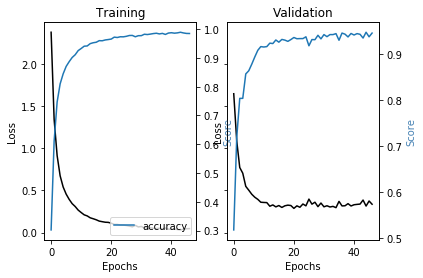

In [90]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [93]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]
predicted_vec = [ inverse_dic[p] for p in predicted]

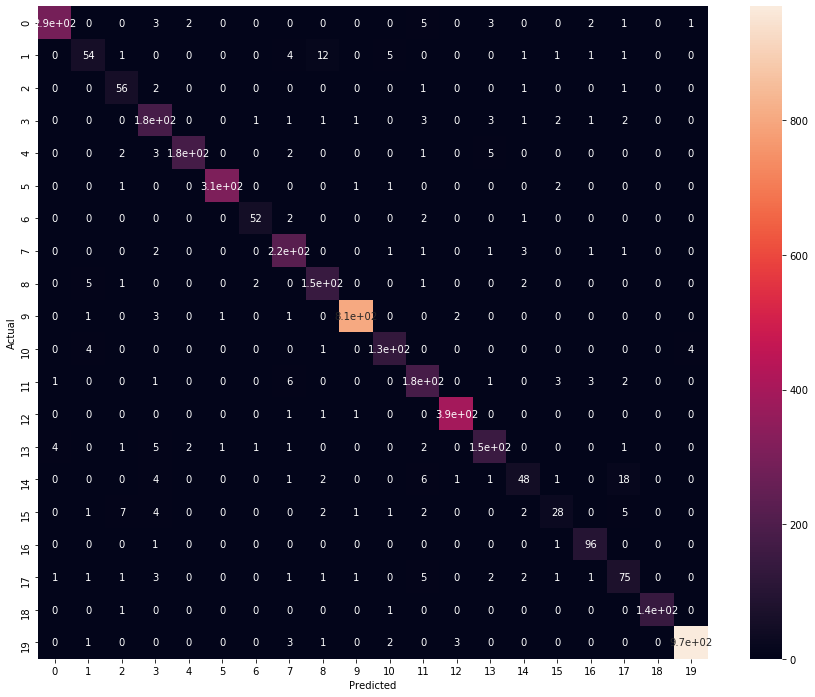

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       305
           1       0.81      0.68      0.73        80
           2       0.79      0.92      0.85        61
           3       0.85      0.92      0.89       197
           4       0.98      0.93      0.95       188
           5       0.99      0.98      0.99       312
           6       0.93      0.91      0.92        57
           7       0.91      0.96      0.93       232
           8       0.87      0.93      0.90       157
           9       0.99      0.99      0.99       814
          10       0.92      0.94      0.93       139
          11       0.86      0.91      0.89       197
          12       0.98      0.99      0.99       397
          13       0.90      0.89      0.90       167
          14       0.79      0.59      0.67        82
          15       0.72      0.53      0.61        53
          16       0.91      0.98      0.95        98
          17       0.70    

In [95]:
conf_mat = m.confusion_matrix(Y_test, predicted_vec,normalize = None)
plt.figure(figsize = (15,12))
sns.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# target_strings = encoder.inverse_transform(np.arange(20))

print(m.classification_report(Y_test, predicted_vec))